In [ ]:
# Global inversion with empymod

#%matplotlib notebook

# Code for Global Inversion 

In [1]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed

Creating a synthetic model

In [2]:
# Define Dualem-482 geometry

offsets = np.array([2, 4, 8]) # in meters
height = -0.10 # meters height From ground surface to center of coils
rad = 0.08 # Define radius of coil (8 cm)

# Source and receivers geometry

# For HCP
Hsource = [-rad, rad, -rad, rad, height, height]
Hreceivers = [offsets-rad, offsets+rad,
              np.ones(3)*-rad, np.ones(3)*rad, height, height]

# For VCP
Vsource = [0, 0, height, 90, 0]
Vreceivers = [offsets, offsets*0, height, 90, 0]

# For PRP
Psource = [0, 0, height]
Preceivers = [offsets, offsets*0, height]

# Frequency
freq = 9000

In [3]:
# parameters for the synthetic model

nlayer = 3 # number of layer
npos = 20 # number of sampling positions

resistivities = [10,50,10]
res = np.ones((npos, nlayer))*resistivities
x = np.linspace(0, 20, npos)[:,None]
thk1 = 2 + 0.2 * np.sin(x*np.pi*2) # wave
thk2 = 2 + np.sin(x*np.pi*2) # wave
depthmax = 10
ny = 50

In [4]:
# Arrays for plotting
y = np.linspace(0, depthmax, ny)
xx = np.linspace(0,npos+1,npos+1, endpoint=False) # For step plot

def PlotResistivities(thk1, thk2, res, npos, ny, Model):
    surface = np.zeros(npos)
    depth = np.zeros((npos,4))

    # Depths to be plotted
    for i in range(npos):
        depth[i,0] = 0
        depth[i,1] = thk1[i]
        depth[i,2] = thk1[i] + thk2[i]
        depth[i,3] = thk1[i] + thk2[i]
        
    resy = np.zeros((npos, ny))

    # Resistivities array to be plotted
    for i in range(npos):
        y1=0
        while y[y1] <= depth[i, 1]:
            resy[i, y1] = res[i, 0]
            y1 += 1
            y2=y1
        while y[y2] <= depth[i, 2]:
            resy[i, y2] = res[i, 1]
            y2 += 1
            if y2 == 50:
                break
        resy[i, y2:] = res[i, 2]
        
    fig, ax = plt.subplots()
    pos = ax.imshow(resy.T, cmap='viridis', interpolation='none', extent=[0,npos,10,0], vmin=1, vmax=100)
    clb = fig.colorbar(pos, shrink=0.5)
    clb.set_label('Resistivity [Ohm . m]',  )
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Position [m]')
    ax.set_title(Model)
        
    return depth, resy

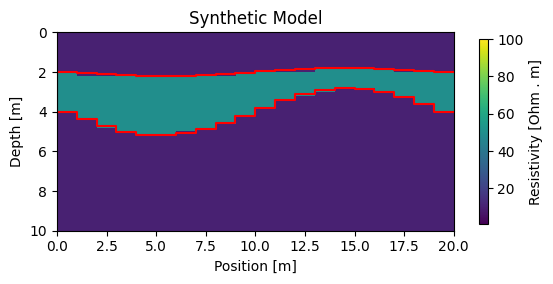

In [5]:
#Plot synthetic model

depth, resy = PlotResistivities(thk1, thk2, res, npos, ny, 'Synthetic Model')

plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])),'r')

Define forward model function

In [6]:
def EMforward(x):
    # x is input model
    surface = np.array([0])
    thkx = np.array(x[0:2])
    depthx = np.hstack((surface, thkx[0], thkx[0]+thkx[1]))
    res_ground = np.array(x[2:])
    res_air = np.array([2e14])
    resx = np.hstack((res_air, res_ground))
    HCP_Hs = -empymod.loop(Hsource, Hreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop',verb=0)
    VCP_Hs = empymod.loop(Vsource, Vreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP_Hs = empymod.dipole(Psource, Preceivers, depthx, resx, freq, ab=64, xdirect=None, verb=0)

    HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=[2e14], freqtime=freq, mrec = 'loop', verb=0)
    VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=[2e14], freqtime=freq, mrec = 'loop', verb=0)
    PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=[2e14], freqtime=freq, ab=66, verb=0)

    Q_HCP = np.imag(HCP_Hs/HCP_Hp)
    Q_VCP = np.imag(VCP_Hs/VCP_Hp)
    Q_PRP = np.imag(PRP_Hs/PRP_Hp)
    
    P_HCP = np.real(HCP_Hs/HCP_Hp)
    P_VCP = np.real(VCP_Hs/VCP_Hp)
    P_PRP = np.real(PRP_Hs/PRP_Hp)   
    
    return np.hstack((Q_HCP, Q_VCP, Q_PRP, P_HCP, P_VCP, P_PRP))

Load solutions hypercube

In [ ]:
Responses_0to11 = np.load('Results_is1_0to11.npy')
Responses_11to21 = np.load('Results_is1_11to21.npy')


### Create synthetic dataset

In [7]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data = []

for i in range(npos):
    model_i = np.array([thk1[i][0], thk2[i][0]]+resistivities) # True model 
    model.append(model_i)
    data.append(EMforward(model_i)) # creating data



### From dataset obtain normalization factors

In [8]:
data = np.array(data)

# data shape is (npos, geometries * 2) 

Q_HCP_2 = data[:,0]
Q_HCP_4 = data[:,1]
Q_HCP_8 = data[:,2]
Q_VCP_2 = data[:,3]
Q_VCP_4 = data[:,4]
Q_VCP_8 = data[:,5]
Q_PRP_2 = data[:,6]
Q_PRP_4 = data[:,7]
Q_PRP_8 = data[:,8]

P_HCP_2 = data[:,9]
P_HCP_4 = data[:,10]
P_HCP_8 = data[:,11]
P_VCP_2 = data[:,12]
P_VCP_4 = data[:,13]
P_VCP_8 = data[:,14]
P_PRP_2 = data[:,15]
P_PRP_4 = data[:,16]
P_PRP_8 = data[:,17]

# Calculate L2 norm

L2_Q_HCP_2 = np.sqrt(np.sum(Q_HCP_2**2))
L2_Q_HCP_4 = np.sqrt(np.sum(Q_HCP_4**2))
L2_Q_HCP_8 = np.sqrt(np.sum(Q_HCP_8**2))

L2_Q_VCP_2 = np.sqrt(np.sum(Q_VCP_2**2))
L2_Q_VCP_4 = np.sqrt(np.sum(Q_VCP_4**2))
L2_Q_VCP_8 = np.sqrt(np.sum(Q_VCP_8**2))

L2_Q_PRP_2 = np.sqrt(np.sum(Q_PRP_2**2))
L2_Q_PRP_4 = np.sqrt(np.sum(Q_PRP_4**2))
L2_Q_PRP_8 = np.sqrt(np.sum(Q_PRP_8**2))

L2_P_HCP_2 = np.sqrt(np.sum(P_HCP_2**2))
L2_P_HCP_4 = np.sqrt(np.sum(P_HCP_4**2))
L2_P_HCP_8 = np.sqrt(np.sum(P_HCP_8**2))

L2_P_VCP_2 = np.sqrt(np.sum(P_VCP_2**2))
L2_P_VCP_4 = np.sqrt(np.sum(P_VCP_4**2))
L2_P_VCP_8 = np.sqrt(np.sum(P_VCP_8**2))

L2_P_PRP_2 = np.sqrt(np.sum(P_PRP_2**2))
L2_P_PRP_4 = np.sqrt(np.sum(P_PRP_4**2))
L2_P_PRP_8 = np.sqrt(np.sum(P_PRP_8**2))

L2_Q_HCP = np.hstack((L2_Q_HCP_2, L2_Q_HCP_4, L2_Q_HCP_8))
L2_Q_VCP = np.hstack((L2_Q_VCP_2, L2_Q_VCP_4, L2_Q_VCP_8))
L2_Q_PRP = np.hstack((L2_Q_PRP_2, L2_Q_PRP_4, L2_Q_PRP_8))

L2_P_HCP = np.hstack((L2_P_HCP_2, L2_P_HCP_4, L2_P_HCP_8))
L2_P_VCP = np.hstack((L2_P_VCP_2, L2_P_VCP_4, L2_P_VCP_8))
L2_P_PRP = np.hstack((L2_P_PRP_2, L2_P_PRP_4, L2_P_PRP_8))

L2 = np.stack((L2_Q_HCP, L2_Q_VCP, L2_Q_PRP, L2_P_HCP, L2_P_VCP, L2_P_PRP))

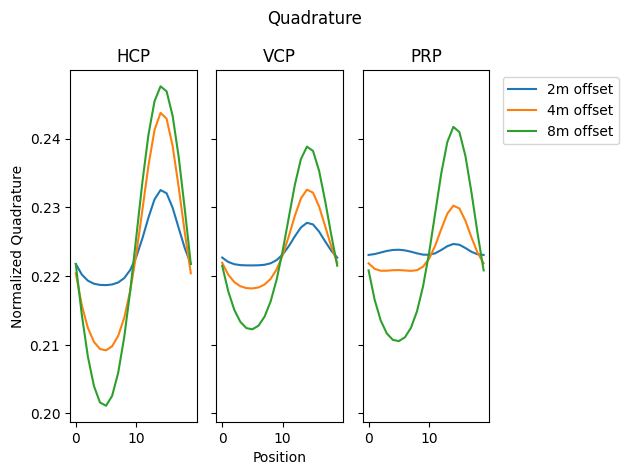

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)

ax1.plot(Q_HCP_2/L2_Q_HCP_2, label='HCP 2')
ax1.plot(Q_HCP_4/L2_Q_HCP_4, label='HCP 4')
ax1.plot(Q_HCP_8/L2_Q_HCP_8, label='HCP 8')
ax1.set_title('HCP')

ax2.plot(Q_VCP_2/L2_Q_VCP_2, label='VCP 2')
ax2.plot(Q_VCP_4/L2_Q_VCP_4, label='VCP 4')
ax2.plot(Q_VCP_8/L2_Q_VCP_8, label='VCP 8')
ax2.set_title('VCP')

ax3.plot(Q_PRP_2/L2_Q_PRP_2, label='2m offset')
ax3.plot(Q_PRP_4/L2_Q_PRP_4, label='4m offset')
ax3.plot(Q_PRP_8/L2_Q_PRP_8, label='8m offset')
ax3.set_title('PRP')
ax3.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax2.set_xlabel('Position')
ax1.set_ylabel('Normalized Quadrature')
fig.suptitle('Quadrature')
plt.tight_layout()

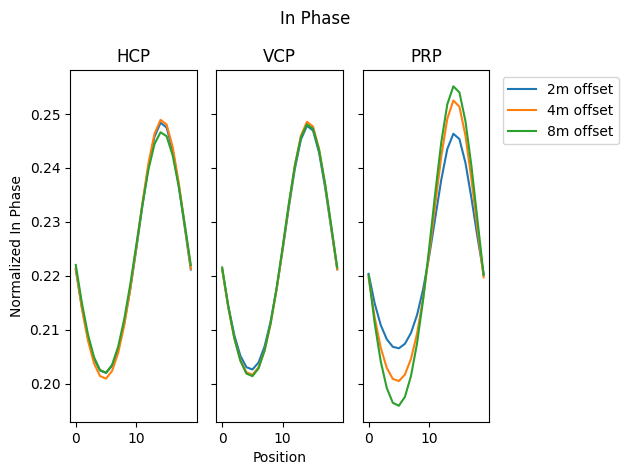

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)

ax1.plot(P_HCP_2/L2_P_HCP_2, label='HCP 2')
ax1.plot(P_HCP_4/L2_P_HCP_4, label='HCP 4')
ax1.plot(P_HCP_8/L2_P_HCP_8, label='HCP 8')
ax1.set_title('HCP')

ax2.plot(P_VCP_2/L2_P_VCP_2, label='VCP 2')
ax2.plot(P_VCP_4/L2_P_VCP_4, label='VCP 4')
ax2.plot(P_VCP_8/L2_P_VCP_8, label='VCP 8')
ax2.set_title('VCP')

ax3.plot(P_PRP_2/L2_P_PRP_2, label='2m offset')
ax3.plot(P_PRP_4/L2_P_PRP_4, label='4m offset')
ax3.plot(P_PRP_8/L2_P_PRP_8, label='8m offset')
ax3.set_title('PRP')
ax3.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax2.set_xlabel('Position')
ax1.set_ylabel('Normalized In Phase')
fig.suptitle('In Phase')
plt.tight_layout()

### Forward function including normalization

In [11]:
def EMforwardn(x):
    # x is input model
    surface = np.array([0])
    thkx = np.array(x[0:2])
    depthx = np.hstack((surface, thkx[0], thkx[0]+thkx[1]))
    res_ground = np.array(x[2:])
    res_air = np.array([2e14])
    resx = np.hstack((res_air, res_ground))
    HCP_Hs = -empymod.loop(Hsource, Hreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop',verb=0)
    VCP_Hs = empymod.loop(Vsource, Vreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP_Hs = empymod.dipole(Psource, Preceivers, depthx, resx, freq, ab=64, xdirect=None, verb=0)

    HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=[2e14], freqtime=freq, mrec = 'loop', verb=0)
    VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=[2e14], freqtime=freq, mrec = 'loop', verb=0)
    PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=[2e14], freqtime=freq, ab=66, verb=0)

    Q_HCP = np.imag(HCP_Hs/HCP_Hp)/L2[0]
    Q_VCP = np.imag(VCP_Hs/VCP_Hp)/L2[1]
    Q_PRP = np.imag(PRP_Hs/PRP_Hp)/L2[2]
    
    P_HCP = np.real(HCP_Hs/HCP_Hp)/L2[3]
    P_VCP = np.real(VCP_Hs/VCP_Hp)/L2[4]
    P_PRP = np.real(PRP_Hs/PRP_Hp)/L2[5]
    
    return np.hstack((Q_HCP, Q_VCP, Q_PRP, P_HCP, P_VCP, P_PRP))

In [12]:
nsl = 21 # sampling number of the cube

s0 = -2 # minimum conductivity in S/m
s1 = -0.8 # maximum conductivity in S/m
# conductivities array
conds = np.logspace(s0, s1, nsl)

th0 = 0.1 # minimum thickness in m
th1 = 5   # maximum thickness in m
# thickness array
thicks = np.linspace(th0, th1, nsl)

In [13]:
def gridsearch(Zdata):    
    err = 1
    for i in range(len(Responses_0to11)):
        Z = Responses_0to11[i]
        nZdiff = np.abs(Z - Zdata) **2 / np.abs(Zdata)**2
        merr = np.log10(np.sqrt(np.sum(nZdiff)))
        #merr = np.sum(nZdiff)

        if merr < err: 
            err = merr
            ind = i
    for i in range(len(Responses_11to21)):
        Z = Responses_11to21[i]
        nZdiff = np.abs(Z - Zdata) **2 / np.abs(Zdata)**2
        merr = np.log10(np.sqrt(np.sum(nZdiff)))
        #merr = np.sum(nZdiff)

        if merr < err: 
            err = merr
            ind = len(Responses_0to11) + i
    #print('Estimated minimum error')
    return ind

In [14]:
def search_model(ind):
    
    for is1 in range(nsl):
        for is2 in range(nsl):
            for is3 in range(nsl):
                for il1 in range(nsl):
                    for il2 in range(nsl):
                        i = il2+(il1)*nsl+(is3)*nsl**2+(is2)*nsl**3+(is1)*nsl**4
                        if i == ind:
                            model = [thicks[il1], thicks[il2], 1/conds[is1], 1/conds[is2], 1/conds[is3]]
                            #print('Estimated model')
                            return model              
                    

In [15]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data = []

for i in range(npos):
    model_i = np.array([thk1[i][0], thk2[i][0]]+resistivities) # True model 
    model.append(model_i)
    data.append(EMforwardn(model_i)) # creating data

In [ ]:
# Relative error array
#error = 1e-3 # introduce here the error you want to test
#relativeError = np.ones_like(data[0]) * error

def inversion(ipos):
    time.sleep(0.1)
    #print('Start position ', ipos)
    dataE = np.array(data[ipos]).copy()
    dataE *= np.random.randn(len(dataE)) #* relativeError + 1.0
    
    grid_i = gridsearch(dataE)
    model_est = search_model(grid_i)
    
    return model_est

# Start inversion

startTime = time.time()

model_est_list = Parallel(n_jobs=-1,verbose=1)(delayed(inversion)(ipos) for ipos in range(npos))

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

In [ ]:
model_est_arr = np.array(model_est_list)

np.save('model_est_arr', model_est_arr)

In [16]:
model_est_arr = np.load('Model_51nsl_norm.npy')

<Figure size 640x480 with 0 Axes>

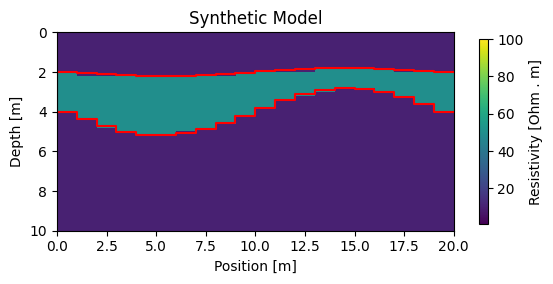

<Figure size 640x480 with 0 Axes>

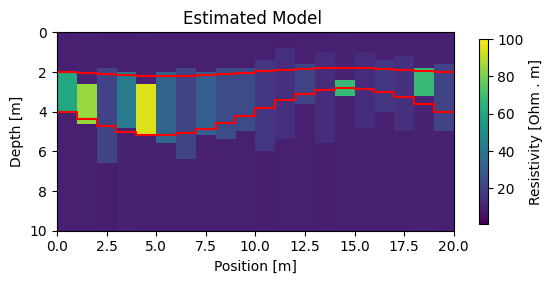

In [17]:
#Plot synthetic model
plt.figure()
depth, resy = PlotResistivities(thk1, thk2, res, npos, ny, 'Synthetic Model')

plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])),'r')

# Plot estimated model
plt.figure()
depth_,resy_ = PlotResistivities(model_est_arr[:,0], model_est_arr[:,1], model_est_arr[:,2:] , npos, ny,
                                 'Estimated Model ')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])), 'r')

In [18]:
Q_HCP_2=[]
Q_HCP_4=[]
Q_HCP_8=[]
P_HCP_2=[]
P_HCP_4=[]
P_HCP_8=[]
Q_VCP_2=[]
Q_VCP_4=[]
Q_VCP_8=[]
P_VCP_2=[]
P_VCP_4=[]
P_VCP_8=[]
Q_PRP_2=[]
Q_PRP_4=[]
Q_PRP_8=[]
P_PRP_2=[]
P_PRP_4=[]
P_PRP_8=[]

for i in range(npos):
    Q_HCP_2.append((data[i][0]))
    Q_HCP_4.append((data[i][1]))
    Q_HCP_8.append((data[i][2]))
    Q_VCP_2.append((data[i][3]))
    Q_VCP_4.append((data[i][4]))
    Q_VCP_8.append((data[i][5]))
    Q_PRP_2.append((data[i][6]))
    Q_PRP_4.append((data[i][7]))
    Q_PRP_8.append((data[i][8]))
    
    P_HCP_2.append((data[i][9]))
    P_HCP_4.append((data[i][10]))
    P_HCP_8.append((data[i][11]))
    P_VCP_2.append((data[i][12]))
    P_VCP_4.append((data[i][13]))
    P_VCP_8.append((data[i][14]))
    P_PRP_2.append((data[i][15]))
    P_PRP_4.append((data[i][16]))
    P_PRP_8.append((data[i][17]))

In [19]:
# Create empty array for true data in each position
dataobs = []

for i in range(npos):
    model_i = model_est_arr[i] # True model 
    dataobs.append(EMforwardn(model_i)) # creating data

In [20]:
Q_HCP_2_est=[]
Q_HCP_4_est=[]
Q_HCP_8_est=[]
P_HCP_2_est=[]
P_HCP_4_est=[]
P_HCP_8_est=[]

Q_VCP_2_est=[]
Q_VCP_4_est=[]
Q_VCP_8_est=[]
P_VCP_2_est=[]
P_VCP_4_est=[]
P_VCP_8_est=[]

Q_PRP_2_est=[]
Q_PRP_4_est=[]
Q_PRP_8_est=[]
P_PRP_2_est=[]
P_PRP_4_est=[]
P_PRP_8_est=[]

for i in range(npos):
    Q_HCP_2_est.append((dataobs[i][0]))
    Q_HCP_4_est.append((dataobs[i][1]))
    Q_HCP_8_est.append((dataobs[i][2]))
    Q_VCP_2_est.append((dataobs[i][3]))
    Q_VCP_4_est.append((dataobs[i][4]))
    Q_VCP_8_est.append((dataobs[i][5]))
    Q_PRP_2_est.append((dataobs[i][6]))
    Q_PRP_4_est.append((dataobs[i][7]))
    Q_PRP_8_est.append((dataobs[i][8]))
    
    P_HCP_2_est.append((dataobs[i][9]))
    P_HCP_4_est.append((dataobs[i][10]))
    P_HCP_8_est.append((dataobs[i][11]))
    P_VCP_2_est.append((dataobs[i][12]))
    P_VCP_4_est.append((dataobs[i][13]))
    P_VCP_8_est.append((dataobs[i][14]))
    P_PRP_2_est.append((dataobs[i][15]))
    P_PRP_4_est.append((dataobs[i][16]))
    P_PRP_8_est.append((dataobs[i][17]))

Text(0.5, 0.98, 'HCP Quadrature')

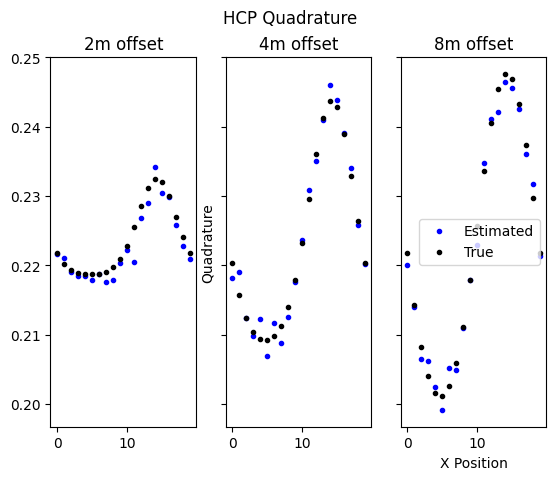

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)

ax1.plot(Q_HCP_2_est, '.b')
ax1.plot(Q_HCP_2, '.k')
ax1.set_title('2m offset')

ax2.plot(Q_HCP_4_est, '.b')
ax2.plot(Q_HCP_4, '.k')
ax2.set_ylabel('Quadrature')
ax2.set_title('4m offset')

ax3.plot(Q_HCP_8_est, '.b', label='Estimated')
ax3.plot(Q_HCP_8, '.k', label='True')
ax3.set_xlabel('X Position')
ax3.set_title('8m offset')
ax3.legend()
fig.suptitle('HCP Quadrature')

Text(0.5, 0.98, 'HCP In Phase')

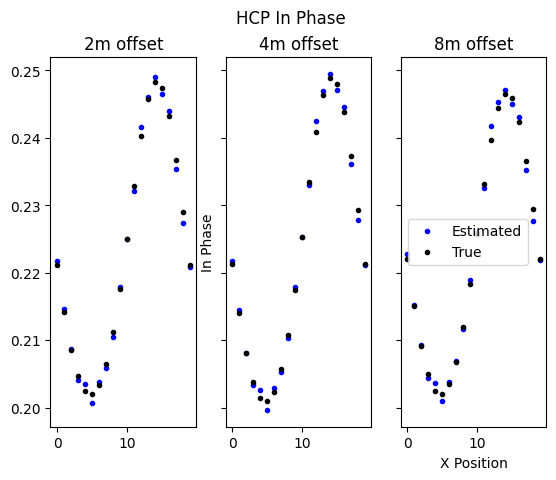

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)

ax1.plot(P_HCP_2_est, '.b')
ax1.plot(P_HCP_2, '.k')
ax1.set_title('2m offset')

ax2.plot(P_HCP_4_est, '.b')
ax2.plot(P_HCP_4, '.k')
ax2.set_ylabel('In Phase')
ax2.set_title('4m offset')

ax3.plot(P_HCP_8_est, '.b', label='Estimated')
ax3.plot(P_HCP_8, '.k', label='True')
ax3.set_xlabel('X Position')
ax3.set_title('8m offset')
ax3.legend()
fig.suptitle('HCP In Phase')

Text(0.5, 0.98, 'VCP Quadrature')

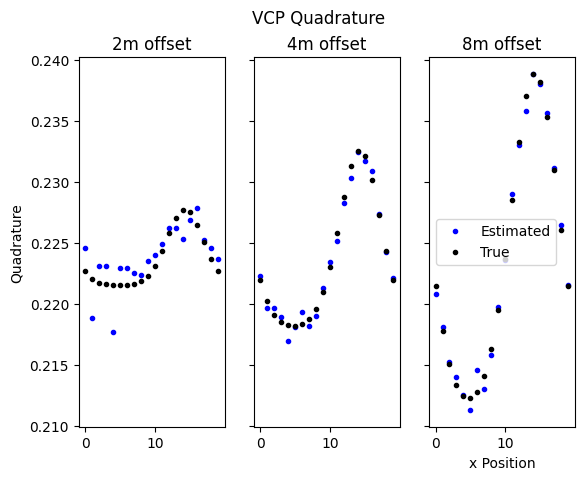

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)

ax1.plot(Q_VCP_2_est, '.b')
ax1.plot(Q_VCP_2, '.k')
ax1.set_title('2m offset')
ax1.set_ylabel('Quadrature')

ax2.plot(Q_VCP_4_est, '.b')
ax2.plot(Q_VCP_4, '.k')
ax2.set_title('4m offset')

ax3.plot(Q_VCP_8_est, '.b', label='Estimated')
ax3.plot(Q_VCP_8, '.k', label='True')
ax3.set_xlabel('x Position')
ax3.set_title('8m offset')
ax3.legend()
fig.suptitle('VCP Quadrature')

Text(0.5, 0.98, 'VCP In Phase')

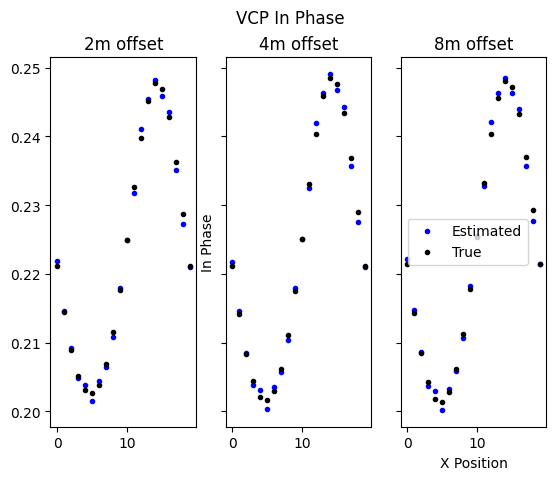

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)

ax1.plot(P_VCP_2_est, '.b')
ax1.plot(P_VCP_2, '.k')
ax1.set_title('2m offset')

ax2.plot(P_VCP_4_est, '.b')
ax2.plot(P_VCP_4, '.k')
ax2.set_ylabel('In Phase')
ax2.set_title('4m offset')

ax3.plot(P_VCP_8_est, '.b', label='Estimated')
ax3.plot(P_VCP_8, '.k', label='True')
ax3.set_xlabel('X Position')
ax3.set_title('8m offset')
ax3.legend()
fig.suptitle('VCP In Phase')

Text(0.5, 0.98, 'PRP Quadrature')

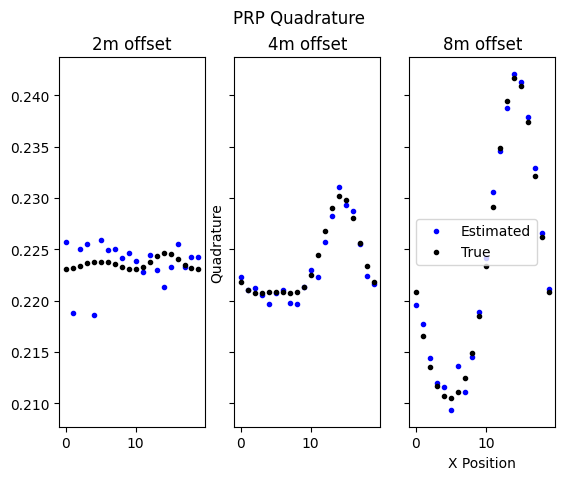

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)

ax1.plot(Q_PRP_2_est, '.b')
ax1.plot(Q_PRP_2, '.k')
ax1.set_title('2m offset')

ax2.plot(Q_PRP_4_est, '.b')
ax2.plot(Q_PRP_4, '.k')
ax2.set_ylabel('Quadrature')
ax2.set_title('4m offset')

ax3.plot(Q_PRP_8_est, '.b', label='Estimated')
ax3.plot(Q_PRP_8, '.k', label='True')
ax3.set_xlabel('X Position')
ax3.set_title('8m offset')
ax3.legend()
fig.suptitle('PRP Quadrature')

Text(0.5, 0.98, 'PRP In Phase')

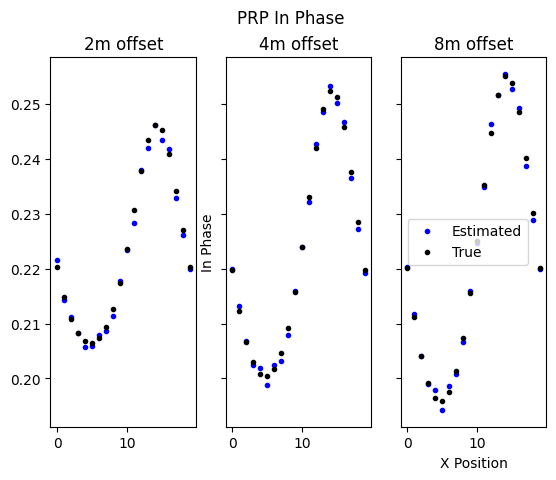

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)

ax1.plot(P_PRP_2_est, '.b')
ax1.plot(P_PRP_2, '.k')
ax1.set_title('2m offset')

ax2.plot(P_PRP_4_est, '.b')
ax2.plot(P_PRP_4, '.k')
ax2.set_ylabel('In Phase')
ax2.set_title('4m offset')

ax3.plot(P_PRP_8_est, '.b', label='Estimated')
ax3.plot(P_PRP_8, '.k', label='True')
ax3.set_xlabel('X Position')
ax3.set_title('8m offset')
ax3.legend()
fig.suptitle('PRP In Phase')